In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
# from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import numpy as np
from windfreak import SynthHD
from math import floor
import time
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# connect to the windfreak mw driver 
synth = SynthHD('COM4')
synth.init()

In [3]:
# connect to devices
uncal_choffset = {"laser":0, 
                "sdtrig":0, 
                "dtrig":900,
                "mwA":0, 
                "mwB":0,
                }
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap, choffs=uncal_choffset) 
# mwsyn = Synthesizer(hcf.VDISYN_SN, 
#                     vidpid=hcf.VDISYN_VIDPID,
#                     baudrate=hcf.VDISYN_BAUD, 
#                     timeout=5, 
#                     write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


In [4]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [5]:
from hardware.daq.sidig import FIFO_DataAcquisition
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

SIDIG_ADDRESS = "dev/spcm0"
SIDIG_maxsr = 500e6  # Hz
SIDIG_timebase = int(1 / SIDIG_maxsr * 1e9)  # ns
dig=FIFO_DataAcquisition(
                sn_address=SIDIG_ADDRESS
            )

Clock mode set to: 32
1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling


In [6]:
# # set MW power =====================================================
# mwpower_vlevel = 5.0 # 5V equals to max power
# task_uca = nidaqmx.Task("UCA") # user controlled attenuation
# task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# # task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
# task_uca.start()
# task_uca.write([mwpower_vlevel], auto_start=False)
# # task_uca.stop()
# # task_uca.close()

In [7]:
def seqtime(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])

In [8]:
pg.reset()
tb = hcf.NI_timebase
# init_laser = 8000.0

init_nslaser = 50
init_isc = 150
init_repeat = 40
init_wait = 1000.0

mw_dur_start = 10.0
mw_dur_end = 3500
mw_dur_step = 50
mw_dur = np.arange(mw_dur_start, mw_dur_end, mw_dur_step)[::-1] # reverse the mw 

mw_dur_num = len(mw_dur)
read_wait = 300.0
read_laser = 900.0



seq_exp = []


sub_init = [(["laser"], init_nslaser), ([], init_isc)]*init_repeat + [([], init_wait)]
# sub_init_fake = [([], init_nslaser), ([], init_isc)]*init_repeat + [([], init_wait)]

sub_evo_MW = [(["mwB"], mw_dur[0])]


sub_read = [([], read_wait), (["laser", "sdtrig"], read_laser),([],10)]
fake_read=[([], read_wait), (["sdtrig"], read_laser)]
# fake_fake_read=[([], read_wait), ([], read_laser)]

seq_exp += sub_init+ sub_evo_MW + sub_read #fake_read + sub_init

seqlet_time_max = seqtime(seq_exp)
srate = 1/seqlet_time_max*1E9 # in Hz

sub_evo_noMW = [([], mw_dur[0])]


seq_exp += sub_init + sub_evo_noMW + sub_read


for mwd in mw_dur[1:]:
# for mwd in mw_dur:

    sub_evo_MW = [(["mwB"], mwd)]

    seqlet_MW = sub_init+sub_evo_MW+sub_read

    seqlet_time = seqtime(seqlet_MW)
    padtime = seqlet_time_max - seqlet_time
    sub_pad = [([], padtime)]

    sub_evo_noMW = [([], mwd)]

    seqlet_noMW = sub_init+sub_evo_noMW+sub_read

    seq_exp += sub_pad + seqlet_MW + sub_pad + seqlet_noMW 


trigwidth = tb*20
# sub_dtrig = [(["dtrig"], trigwidth)]
sub_read = [([], read_wait), (["sdtrig"], read_laser)]
padtime = seqlet_time_max  - seqtime(sub_read)
seqlet_bias = [([], padtime)]  #+ sub_read
total_time = pg.setSequence(
    seqlet_bias + seq_exp
) 


In [9]:
def seqtime_tb(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])
def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
REPEAT_INFINITELY = -1
pg.stream(n_runs=REPEAT_INFINITELY)
pg.plotSeq(plot_all=False)

In [10]:
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
rate_refresh = 10 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
t_seq = total_time
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size=int((read_wait/2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
posttrig_size=int((read_laser)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and init_isc
segment_size = pretrig_size+posttrig_size
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [11]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=num_segment,
             pretrig_size=pretrig_size+256,
             posttrig_size=posttrig_size-256,
             segment_size=segment_size,
             terminate_input=TERMIN_INPUT_1MOHM,
             couple_input=0
             ))


In [ ]:
# sig_bbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
# sig_dbloc = np.zeros((mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
read_duration = 30 # read data for ? seconds
# num_repeat = 10
data_store = np.zeros((2*mw_dur_num, pretrig_size+posttrig_size), dtype=np.float64, order='C')
bg_store= np.zeros((31139,pretrig_size+posttrig_size))
laser.laser_on() # turn on laser
dig.set_config() # set the configuration
dig.start_buffer() # start the buffer
pg.startNow()
ch = synth[0]  
ch.power = 20
ch.frequency = (398.544*1e9)/24
ch.enable = True
synth.enable=True
start_time = time.time()
  

segments=np.zeros(2*mw_dur_num, dtype=np.float64, order='C')
idx_pointer = 0

while time.time() - start_time < read_duration:

    rawraw = dig.stream()
    
    if rawraw is not None:
       
        num_segs = np.shape(rawraw)[0]

        for i in range(num_segs):
            idx=(idx_pointer+i)%(2*mw_dur_num)
            data_store[idx,:]+=np.ravel(rawraw[i,:]) #-np.ravel(data_store[0,:])
            segments[idx]+=1
        idx_pointer+=num_segs
       

        idx_pointer = idx_pointer%(2*mw_dur_num)  
            

dig.stop_card()



Card stopped


In [13]:
# turn off laser and set diode current to zero

synth[0].enable = False
synth.enable=False
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()

# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()

In [14]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
pg.reboot()
synth[0].enable = False
synth.enable=False


In [15]:
sig_bbloc=data_store[0::2,:]
sig_dbloc=data_store[1::2,:]
slice=data_store[:,400:800]
temp1=np.mean(slice, axis=1)
temp=temp1/segments



# buffer_bbloc, buffer_dbloc = average_repeated_data(input, 400,800, idx_pointer,reps)



[]

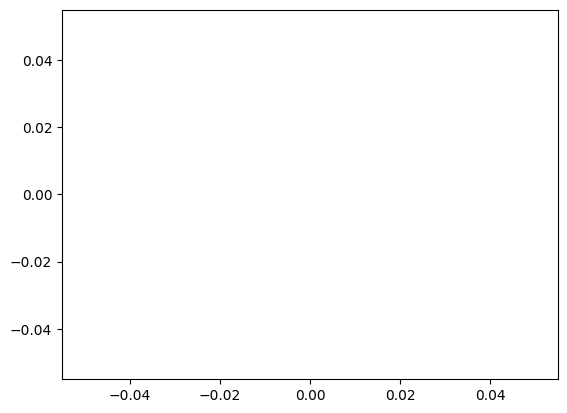

In [16]:
plt.plot()

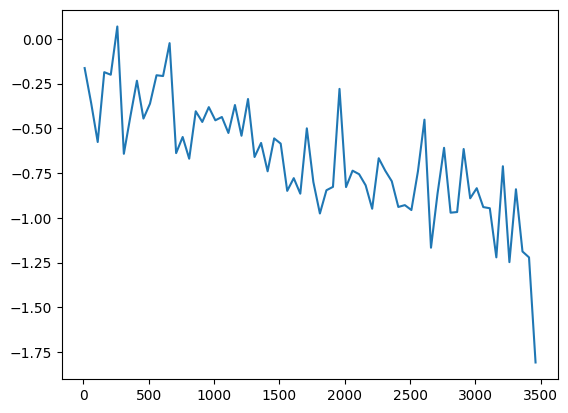

: 

In [ ]:
plt.plot(mw_dur,temp1[0::2]-temp1[1::2])